# Kaggle Titanic

## ライブラリのインポート

In [540]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## データの処理

In [541]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
df = pd.concat([train, test], axis=0, sort=False)

In [542]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### 特徴量生成 (不可逆)

In [543]:
# 家族の人数 Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# 敬称 Title
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.',expand=False)
# Cabinの1文字目を抽出
df['Cabin_init'] = df['Cabin'].str[:1]
df['Cabin_init'] = df['Cabin_init'].fillna('U')
# Fareの欠損値に中央値を代入
# df['Fare'] = df['Fare'].fillna(df['Fare'].median())
# Fareの外れ値を99%内に
df['Fare'] = scipy.stats.mstats.winsorize(df["Fare"], limits=[0.01, 0.01])
# Ticketの重複ありを1,それ以外を0にマッピング

# df['Ticket'] = df['Ticket'].duplicated()*1
# df['Fare'] = pd.qcut(df['Fare'],10)
# df.describe()

# bins = list(range(0,100,10))
# s = pd.cut(df['Fare'], bins).value_counts().sort_index()
# display(s)

# Cabinの重複ありを1,それ以外を0にマッピング
# df['Cabin'] = df['Cabin'].duplicated()*1
# Ticketを出現回数に変換
# Ticketの出現回数順になるのでreset_index。testも振り直しになるので分割後reset_index
ticket = pd.DataFrame(df['Ticket'].value_counts(sort=False),index=None)
ticket = ticket.reset_index().rename(columns={'Ticket':'Ticket_cnt','index':'Ticket'})
df = pd.merge(df,ticket, on='Ticket').sort_values('PassengerId').reset_index(drop=True)

In [544]:
# カテゴリ(数値の大小が意味を持たず、数値を入れ替えても支障ない変数)
# Tableauで可視化するときはコメントアウト
# le = LabelEncoder()
# le.fit(df['Sex'])
# df['Sex'] = le.transform(df['Sex'])
# le.fit(df['Embarked'])
# df['Embarked'] = le.transform(df['Embarked'])
# le.fit(df['Cabin'])
# df['Cabin'] = le.transform(df['Cabin'])
# # df['Cabin'] = [1 if x>1 else 0 for x in df['Cabin']] #Cabin 1以上の場合は全て1
# le.fit(df['Title'])
# df['Title'] = le.transform(df['Title'])

# def title_to_num(title):
#     if title == 'Master':
#         return 1
#     elif title == 'Miss':
#         return 2
#     elif title == 'Mr':
#         return 3
#     elif title == 'Mrs':
#         return 4
#     else:
#         return 5
# df['Title_num'] = [title_to_num(i) for i in df['Title']]

In [545]:
# Ageの欠損値に0を代入
df['Age'] = df['Age'].fillna(100).copy()

In [546]:
df.drop([
         'Name',
         'Ticket',
         # 'Title'
        ], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Survived      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Sex           1309 non-null   object 
 4   Age           1309 non-null   float64
 5   SibSp         1309 non-null   int64  
 6   Parch         1309 non-null   int64  
 7   Fare          1309 non-null   float64
 8   Cabin         1309 non-null   object 
 9   Embarked      1307 non-null   object 
 10  FamilySize    1309 non-null   int64  
 11  Title         1309 non-null   object 
 12  Ticket_count  1309 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 133.1+ KB


## データの可視化

In [547]:
train = df.iloc[:len(train),:].copy()
train['Survived'] = train['Survived'].astype('int64')

In [548]:
test = df.iloc[len(train):,:].copy()
test.drop(['Survived'], axis=1, inplace=True)
test = test.reset_index(drop=True)

In [549]:
# def hide_current_axis(*args, **kwds):
#     plt.gca().set_visible(False)

# plot = sns.pairplot(train, hue='Survived')
# plot.map_upper(hide_current_axis)
# plot.savefig('../output/pairplot.png')
# plt.show()

In [550]:
# import pandas_profiling as pdp
# pdp.ProfileReport(train)

## モデルの学習・予測

In [551]:
X_train = train.drop(['Survived'], axis=1)
Y_train = train['Survived']

In [518]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, Y_train, test_size=0.33, random_state=0)

gbm = lgb.LGBMClassifier(objective='binary',
                         num_leaves=64,
                         min_child_samples=20,
                         max_depth=5,
                        )

gbm.fit(train_x, train_y, eval_set = [(valid_x, valid_y)],
        categorical_feature=[
                             #'PassengerId',
                             # 'Survived',
                             'Pclass',
                             'Sex',
                             # 'Age',
                             # 'SibSp',
                             # 'Parch',       
                             # 'Ticket', 
                             # 'Fare', 
                             'Cabin', 
                             'Embarked', 
                             'Title', 
                             # 'FamilySize'
                             # 'Ticket_count'
                             ],
        early_stopping_rounds=20, verbose=20,
       )

[20]	valid_0's binary_logloss: 0.409659
[40]	valid_0's binary_logloss: 0.39863


/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/estyle-085/opt/anaconda3/env

LGBMClassifier(max_depth=5, num_leaves=64, objective='binary')

In [519]:
oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
print('score',round(accuracy_score(valid_y,oof)*100,2))

score 82.37


In [520]:
test_pred = gbm.predict(test, num_iteration=gbm.best_iteration_)
test_pred = pd.DataFrame(test_pred,  columns=['Survived'])
submission = pd.DataFrame(test['PassengerId'])
submission = pd.concat([submission, test_pred], axis=1)
submission['Survived'].sum()/submission['Survived'].count()

0.284688995215311

In [521]:
pd.DataFrame({'特徴':X_train.columns,
             'importance':gbm.booster_.feature_importance(importance_type='gain')}).sort_values('importance',ascending=False)

,特徴,importance
2,Sex,947.352087
3,Age,396.866202
1,Pclass,244.762230
6,Fare,238.276518
0,PassengerId,185.651881
11,Ticket_count,95.953556
10,Title,67.826191
8,Embarked,61.586114
9,FamilySize,37.012744
4,SibSp,16.117198


<AxesSubplot:>

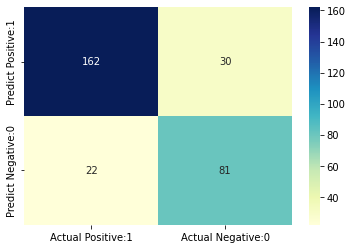

In [522]:
cm = confusion_matrix(oof,valid_y)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [523]:
submission.to_csv('submission.csv',index=False)

In [561]:
train.to_csv('train_tableau2.csv',index=False)

In [559]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,Title,Ticket_count
0,1,0,3,male,22.0,1,0,7.2500,U,S,2,Mr,1
1,2,1,1,female,38.0,1,0,71.2833,C,C,2,Mrs,2
2,3,1,3,female,26.0,0,0,7.9250,U,S,1,Miss,1
3,4,1,1,female,35.0,1,0,53.1000,C,S,2,Mrs,2
4,5,0,3,male,35.0,0,0,8.0500,U,S,1,Mr,1


In [560]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin             0
Embarked          2
FamilySize        0
Title             0
Ticket_count      0
dtype: int64